In [1]:
# Word2Vec 모델을 간단하게 구현해봅니다.
import tensorflow as tf
#import matplotlib
#import matplotlib.pyplot as plt
import numpy as np

In [2]:
sentences=[]
x=0
with open('canonical_smiles.txt', 'r') as smile:
    for line in smile:
        if x<=60000:
            sentences.append(line[:-1])
            x+=1
        else:
            break

In [3]:
word_sequence = list("".join(sentences))
word_list = list(set(list("".join(sentences))))
# 문자열로 분석하는 것 보다, 숫자로 분석하는 것이 훨씬 용이하므로
# 리스트에서 문자들의 인덱스를 뽑아서 사용하기 위해,
# 이를 표현하기 위한 연관 배열과, 단어 리스트에서 단어를 참조 할 수 있는 인덱스 배열을 만듭니다.
word_dict = {w: i for i, w in enumerate(word_list)}

In [4]:
skip_grams = []

for i in range(1, len(word_sequence) - 1):
    # (context, target) : ([target index - 1, target index + 1], target)
    # 스킵그램을 만든 후, 저장은 단어의 고유 번호(index)로 저장합니다
    target = word_dict[word_sequence[i]]
    context = [word_dict[word_sequence[i - 1]], word_dict[word_sequence[i + 1]]]

    # (target, context[0]), (target, context[1])..
    for w in context:
        skip_grams.append([target, w])

In [5]:
# skip-gram 데이터에서 무작위로 데이터를 뽑아 입력값과 출력값의 배치 데이터를 생성하는 함수
def random_batch(data, size):
    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(data)), size, replace=False)

    for i in random_index:
        random_inputs.append(data[i][0])  # target
        random_labels.append([data[i][1]])  # context word

    return random_inputs, random_labels

In [6]:
#########
# 옵션 설정
######

# 학습을 반복할 횟수
training_epoch = 300
# 학습률
learning_rate = 0.001
# 한 번에 학습할 데이터의 크기
batch_size = 20
# 단어 벡터를 구성할 임베딩 차원의 크기
embedding_size = 128
# word2vec 모델을 학습시키기 위한 nce_loss 함수에서 사용하기 위한 샘플링 크기
# batch_size 보다 작아야 합니다.
num_sampled = 15
# 총 단어 갯수
voc_size = len(word_list)

In [7]:
#########
# 신경망 모델 구성
######

inputs = tf.placeholder(tf.int32, shape=[batch_size])
# tf.nn.nce_loss 를 사용하려면 출력값을 이렇게 [batch_size, 1] 구성해야합니다.
labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

# word2vec 모델의 결과 값인 임베딩 벡터를 저장할 변수입니다.
# 총 단어 갯수와 임베딩 갯수를 크기로 하는 두 개의 차원을 갖습니다.
embeddings = tf.Variable(tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))
# 임베딩 벡터의 차원에서 학습할 입력값에 대한 행들을 뽑아옵니다.
# 예) embeddings     inputs    selected
#    [[1, 2, 3]  -> [2, 3] -> [[2, 3, 4]
#     [2, 3, 4]                [3, 4, 5]]
#     [3, 4, 5]
#     [4, 5, 6]]
selected_embed = tf.nn.embedding_lookup(embeddings, inputs)

# nce_loss 함수에서 사용할 변수들을 정의합니다.
nce_weights = tf.Variable(tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))
nce_biases = tf.Variable(tf.zeros([voc_size]))

# nce_loss 함수를 직접 구현하려면 매우 복잡하지만,
# 함수를 텐서플로우가 제공하므로 그냥 tf.nn.nce_loss 함수를 사용하기만 하면 됩니다.
loss = tf.reduce_mean(
            tf.nn.nce_loss(nce_weights, nce_biases, labels, selected_embed, num_sampled, voc_size))

train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [8]:
#########
# 신경망 모델 학습
######

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    
    for step in range(1, training_epoch + 1):
        batch_inputs, batch_labels = random_batch(skip_grams, batch_size)

        _, loss_val = sess.run([train_op, loss],
                               feed_dict={inputs: batch_inputs,
                                          labels: batch_labels})
        
        if step % 10 == 0:
            print("loss at step ", step, ": ", loss_val)
    
    # matplot 으로 출력하여 시각적으로 확인해보기 위해
    # 임베딩 벡터의 결과 값을 계산하여 저장합니다.
    # with 구문 안에서는 sess.run 대신 간단히 eval() 함수를 사용할 수 있습니다.
    trained_embeddings = embeddings.eval()

loss at step  10 :  33.66213
loss at step  20 :  31.348011
loss at step  30 :  26.845179
loss at step  40 :  27.197163
loss at step  50 :  32.03303
loss at step  60 :  27.637335
loss at step  70 :  25.829
loss at step  80 :  20.789272
loss at step  90 :  21.646671
loss at step  100 :  25.595493
loss at step  110 :  16.74318
loss at step  120 :  20.437244
loss at step  130 :  20.648483
loss at step  140 :  28.33461
loss at step  150 :  18.210194
loss at step  160 :  17.464407
loss at step  170 :  8.396166
loss at step  180 :  16.34445
loss at step  190 :  13.447302
loss at step  200 :  9.897798
loss at step  210 :  16.788063
loss at step  220 :  12.894503
loss at step  230 :  18.146406
loss at step  240 :  11.926436
loss at step  250 :  12.206682
loss at step  260 :  8.943416
loss at step  270 :  12.684019
loss at step  280 :  7.9848585
loss at step  290 :  12.682647
loss at step  300 :  13.05163


In [9]:
trained_embeddings

array([[-0.04470645,  0.5813424 , -0.469421  , ...,  0.65141046,
         0.5595703 ,  0.98653674],
       [-0.32991096, -0.33756134, -0.2760255 , ..., -0.67208964,
        -0.95571476, -0.32273293],
       [ 0.30056918,  0.1109685 , -0.01134118, ...,  0.8365967 ,
        -0.46165082, -0.19993022],
       ...,
       [ 0.24328661,  0.2032044 , -0.45493078, ..., -0.3384049 ,
        -0.6217096 , -0.9610717 ],
       [-0.4398586 ,  0.19250542, -0.7745444 , ..., -0.02484126,
        -0.5446999 ,  0.25845104],
       [-0.7917899 ,  0.2032613 , -0.10718147, ..., -0.2847404 ,
         0.43253204,  0.29784298]], dtype=float32)

In [12]:
trained_embeddings.shape

(50, 128)

In [13]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

In [14]:
dix={}
with open("dic.txt", "r") as dic:
    for index, line in enumerate(dic.readlines()):
        dix[line[0]]=index
    
def smilecode(code):
    chlist=list(code)
    reslist=[]
    for item in chlist:
        reslist.append(dix[item])
    return reslist

temp_x=[]
temp_y=[]

with open("new 1.txt", "r") as toxic:
    for line in toxic:
        linlist=line.split("\t")
        temp_x.append(smilecode(linlist[0]))
        temp_y.append(int(linlist[5]))

from random import shuffle

ln = len(temp_x)
ind=[i for i in range(ln)]
shuffle(ind)

for i in ind:
    temp_x.append(temp_x[i])
    temp_y.append(temp_y[i])
temp_x=temp_x[ln:]
temp_y=temp_y[ln:]

n=int(ln*0.2)

train_data=temp_x[n:]
test_data=temp_x[:n]
train_labels=temp_y[n:]
test_labels=temp_y[:n]

import numpy as np

def vectorize_sequences(sequences, dimension=56):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence]=1.
    return results

x_train = vectorize_sequences(train_data)
x_test = vectorize_sequences(test_data)

y_train = np.asarray(train_labels).astype("float32")
y_test = np.asarray(test_labels).astype("float32")

In [15]:
from keras import models
from keras import layers
from keras.initializers import Constant
from keras import optimizers

# Embedding
max_features = 51
maxlen = 56
embedding_size = 128

# Convolution
kernel_size = 5
filters = 64
pool_size = 4

# LSTM
lstm_output_size = 128

In [18]:
model = models.Sequential()

model.add(layers.Embedding(max_features,
                           embedding_size,
                           input_length=maxlen,
                           embeddings_initializer=Constant(trained_embeddings),
                           trainable=False))

model.add(layers.Dropout(0.3))
model.add(layers.Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu'))
model.add(layers.MaxPooling1D(pool_size=pool_size))
model.add(layers.Bidirectional(layers.GRU(lstm_output_size)))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.Adam(lr=0.002, decay=0.025),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train,
                    y_train,
                    epochs=300,
                    validation_data=(x_test, y_test))

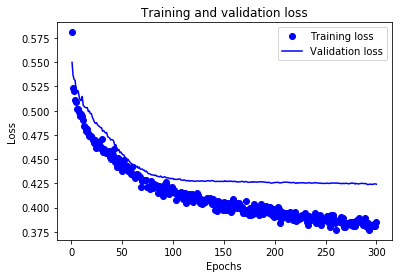

In [21]:
history_dict = history.history

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

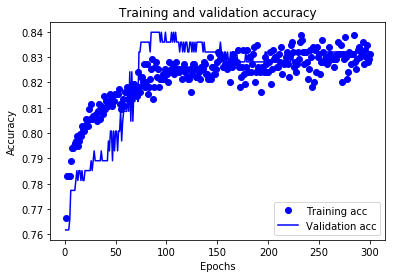

In [22]:
plt.clf()   # 그래프를 초기화합니다
acc = history_dict['acc']
val_acc = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()